## Correcting for "glint"

Some CHEOPS data sets are affected by _glint_ - artefacts caused by scattered light that is not removed by the data reduction pipeline. These are thought to be caused by internal reflections within the telescope structure, e.g., moonlight reflected from the secondary mirror vanes.

To account for glint we can construct a smooth function as a function of the spacecraft roll angle. This can be constructed from the data outside the eclipse or by fitting the residuals from an initial fit to the data. In this notebook we fit the residuals from an initial least-squares fit.

This notebook demonstrates the correction for glint within `pycheops`  by injecting a simulated glint artefact into a simulated dataset. 

In [1]:
%pylab inline
from pycheops import Dataset, StarProperties
from uncertainties import ufloat

# Temporary(?) fix for problem with coordinate look-up for HD stars in astropy 
from astropy.coordinates.name_resolve import sesame_database
sesame_database.set('simbad');


Populating the interactive namespace from numpy and matplotlib


### Load  dataset
Using the same CHEOPSim simulated dataset as `dataset_fit_eclipse_from_simulation`.

In [2]:
#dataset=Dataset.from_test_data('DP-079', target='HD97658')
dataset = Dataset('CH_PR900048_TG001501_V0000', target='HD97658')
_  = dataset.get_lightcurve(aperture='OPTIMAL')

time, flux, flux_err = dataset.clip_outliers(verbose=True)

Found archive tgzfile /Users/pflm/pycheops_data/CH_PR900048_TG001501_V0000.tgz
 PI name     : CHEOPSim
 OBS ID      : 7649
 Target      : HD97658
 Coordinates : 11:14:33.16 +25:42:37.4
 Spec. type  : K1
 V magnitude : 7.71 +- 0.00
Light curve data loaded from  /Users/pflm/pycheops_data/CH_PR900048_TG001501_V0000-OPTIMAL.fits
Time stored relative to BJD = 2458942
Aperture radius used = 17 arcsec
Mean counts = 97182778.5
Median counts = 97196778.9
RMS counts = 39092.5 [402 ppm]
Median standard error = 10065.7 [104 ppm]

Rejected 2 points more than 5.0 x MAD = 583 ppm from the median


### Estimate stellar density and limb darkening from parameters in SWEET-Cat 

Prior on mean stellar density is helpful to constrain the width of the eclipse.

In [3]:
pHD97658 = StarProperties(dataset.target)
print(pHD97658)
logrhoprior = pHD97658.logrho
# logrhoprior = ufloat(0.0593, 0.1556) # for offline user

Identifier : HD97658
Coordinates: 11:14:33.16 +25:42:37.4
T_eff :  5137 +/- 36 K   [SWEET-Cat]
log g :  4.47 +/- 0.09    [SWEET-Cat]
[M/H] : -0.35 +/- 0.02    [SWEET-Cat]
log rho :  0.06 +/- 0.16  (solar units)
h_1 : 0.710 +/- 0.010     [Stagger]
h_2 : 0.439 +/- 0.051     [Stagger]



### Least-squares fit

 

In [4]:
result = dataset.lmfit_transit(P=ufloat(9.489264,0.00001), T_0=ufloat(0.890,0.001),
                               h_1=pHD97658.h_1, h_2=pHD97658.h_2.n, 
                              logrhoprior=logrhoprior)
print(dataset.lmfit_report(min_correl=0.5))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 128
    # data points      = 578
    # variables        = 7
    chi-square         = 1377.01906
    reduced chi-square = 2.41159206
    Akaike info crit   = 515.763231
    Bayesian info crit = 546.280248
    RMS residual       = 160.3 ppm
[[Variables]]
    T_0:     0.89063260 +/- 4.3943e-04 (0.05%) (init = 0.89)
    P:       9.48926400 +/- 1.5529e-05 (0.00%) (init = 9.489264)
    D:       7.4760e-04 +/- 6.3015e-05 (8.43%) (init = 0.001222984)
    W:       0.01428885 +/- 1.4622e-04 (1.02%) (init = 0.02208278)
    b:       0.42914365 +/- 0.29440634 (68.60%) (init = 0.5)
    f_c:     0 (fixed)
    f_s:     0 (fixed)
    h_1:     0.70072953 +/- 0.01455712 (2.08%) (init = 0.71)
    h_2:     0.439 (fixed)
    c:       1.00009660 +/- 8.0954e-06 (0.00%) (init = 1)
    k:       0.02734235 +/- 0.00115234 (4.21%) == 'sqrt(D)'
    aR:      20.7935601 +/- 3.17492463 (15.27%) == 'sqrt((1+k)**2-b**2)/W/pi'
    sini:    0.999

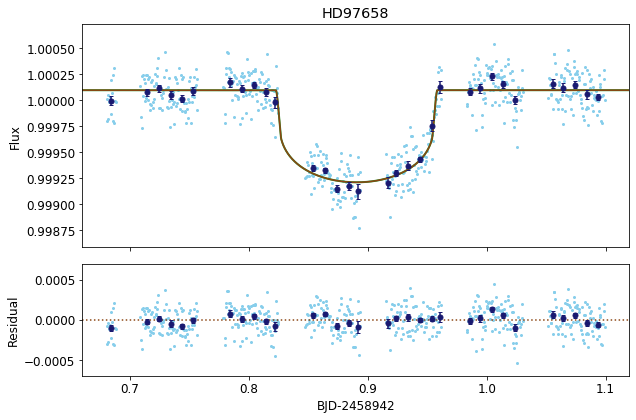

In [5]:
fig = dataset.plot_lmfit(title=dataset.target,figsize=(9,6),fontsize=12)

### Injection of a simulated glint artefact

Glint artefacts tend to show a peak with a dip either side caused by the scattered light perturbing the background flux estimate. Approximate this with a sinc function.

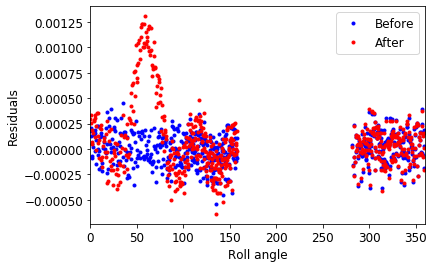

In [6]:
A_glint = 140 ## Amplitude of glint artefact in ppm
angle = np.array(dataset.lc['roll_angle'])
flux = np.array(dataset.lc['flux'])
fit = dataset.lmfit.bestfit
res = flux - fit
plt.plot(angle,res,'b.',label='Before')

phi = (angle-60)*np.pi/180
gfunc = A_glint*1e-6*sin(8*phi)/phi
flux = flux + gfunc
res = flux - fit
plt.plot(angle,res,'r.',label='After')
plt.xlabel('Roll angle')
plt.ylabel('Residuals')
plt.legend()
plt.xlim(0,360)
dataset.lc['flux'] = flux

### Fit to residuals


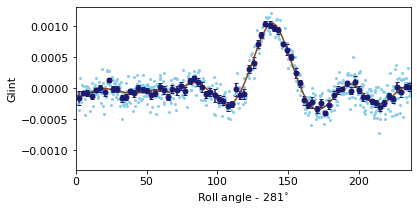

In [7]:
result = dataset.lmfit_transit(P=ufloat(9.489264,0.00001), T_0=ufloat(0.890,0.001),
                               h_1=pHD97658.h_1, h_2=pHD97658.h_2.n,
                              logrhoprior=logrhoprior) 
glint = dataset.add_glint(16, binwidth=3)

### Least squares fit including glint model

In [8]:
result = dataset.lmfit_transit(P=ufloat(9.489264,0.00001), T_0=ufloat(0.890,0.001),
                               h_1=pHD97658.h_1, h_2=pHD97658.h_2.n,
                              logrhoprior=logrhoprior, glint_scale=(0,2)) 
print(dataset.lmfit_report())


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 187
    # data points      = 578
    # variables        = 8
    chi-square         = 1264.74297
    reduced chi-square = 2.21884732
    Akaike info crit   = 468.603088
    Bayesian info crit = 503.479679
    RMS residual       = 153.6 ppm
[[Variables]]
    T_0:          0.89000910 +/- 3.5101e-04 (0.04%) (init = 0.89)
    P:            9.48926400 +/- 1.4896e-05 (0.00%) (init = 9.489264)
    D:            7.2308e-04 +/- 5.9240e-05 (8.19%) (init = 0.001224343)
    W:            0.01416253 +/- 1.2406e-04 (0.88%) (init = 0.02208278)
    b:            0.19153771 +/- 0.75482659 (394.09%) (init = 0.5)
    f_c:          0 (fixed)
    f_s:          0 (fixed)
    h_1:          0.70377569 +/- 0.01389480 (1.97%) (init = 0.71)
    h_2:          0.439 (fixed)
    c:            1.00017454 +/- 7.7432e-06 (0.00%) (init = 1)
    glint_scale:  1.02767768 +/- 0.02312064 (2.25%) (init = 1)
    k:            0.02689010 +/- 0.0011015

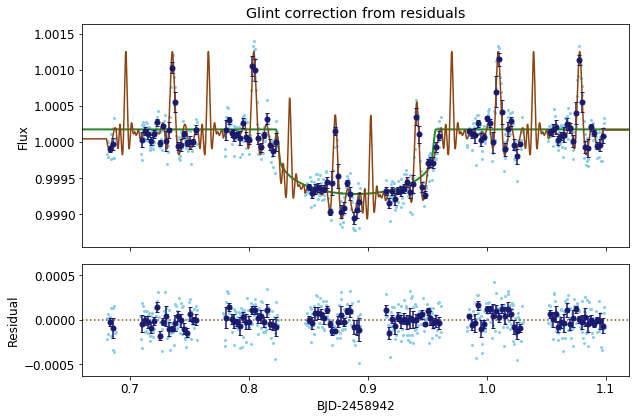

In [9]:
fig = dataset.plot_lmfit(title='Glint correction from residuals',
                         figsize=(9,6),fontsize=12,binwidth=0.0025)

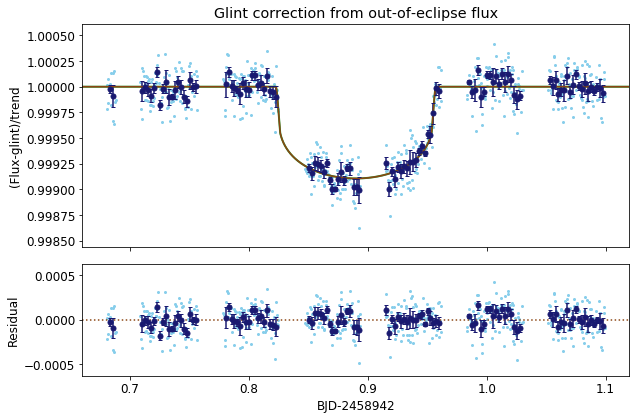

In [10]:
fig = dataset.plot_lmfit(title='Glint correction from out-of-eclipse flux',
                         figsize=(9,6),fontsize=12,binwidth=0.0025,detrend=True)


### Sampling the posterior
Sampling the posterior probability distribution using the affine-invariant sampler [emcee](https://emcee.readthedocs.io/en/stable/). 

The $\pm$1-sigma limits on parameters from the prior are indicated in the corner plot using dashed lines.

This return value from emcee_transit is an instance of an [EnsembleSampler](https://emcee.readthedocs.io/en/latest/user/sampler/) object.

In [11]:
sampler = dataset.emcee_sampler()
print(dataset.emcee_report(min_correl=0.5))

Running burn-in ..


100%|██████████| 256/256 [01:54<00:00,  2.24it/s]

Running sampler ..



100%|██████████| 512/512 [03:42<00:00,  2.30it/s]

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 32768
    # data points      = 574
    # variables        = 9
    chi-square         = 1265.72398
    reduced chi-square = 2.24021943
    Akaike info crit   = -8447.12567
    Bayesian info crit = -8407.95201
    RMS residual       = 153.7 ppm
[[Variables]]
    T_0:          0.89013042 +/- 4.4141e-04 (0.05%) (init = 0.89)
    P:            9.48926447 +/- 9.4438e-06 (0.00%) (init = 9.489264)
    D:            7.5401e-04 +/- 4.1231e-05 (5.47%) (init = 0.001224343)
    W:            0.01419762 +/- 1.2545e-04 (0.88%) (init = 0.02208278)
    b:            0.42284959 +/- 0.20644644 (48.82%) (init = 0.5)
    f_c:          0 (fixed)
    f_s:          0 (fixed)
    h_1:          0.70720111 +/- 0.01032333 (1.46%) (init = 0.71)
    h_2:          0.439 (fixed)
    c:            1.00017381 +/- 7.4350e-06 (0.00%) (init = 1)
    glint_scale:  1.02873683 +/- 0.02365293 (2.30%) (init = 1)
    k:            0.02745918 +/- 0.001101

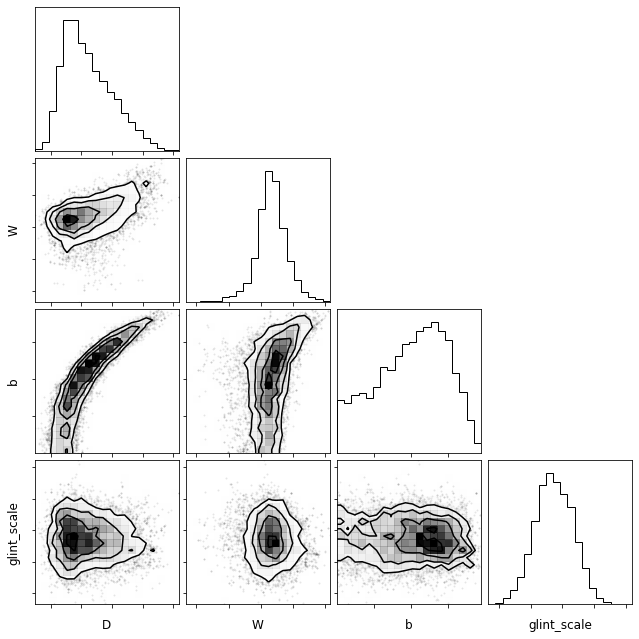

In [12]:
cornerplot = dataset.corner_plot(['D','W','b','glint_scale'])

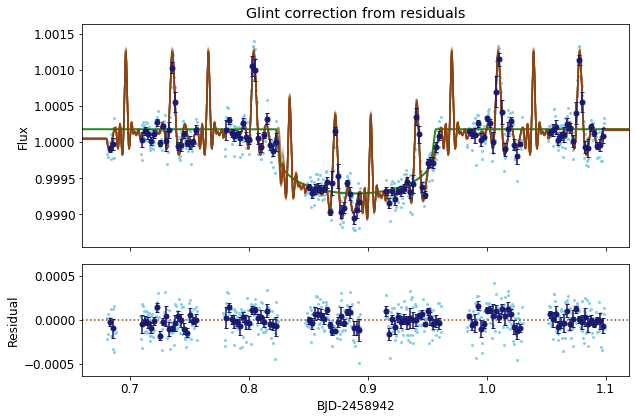

In [13]:
fig = dataset.plot_emcee(title='Glint correction from residuals',
                         figsize=(9,6),fontsize=12, binwidth=0.0025)

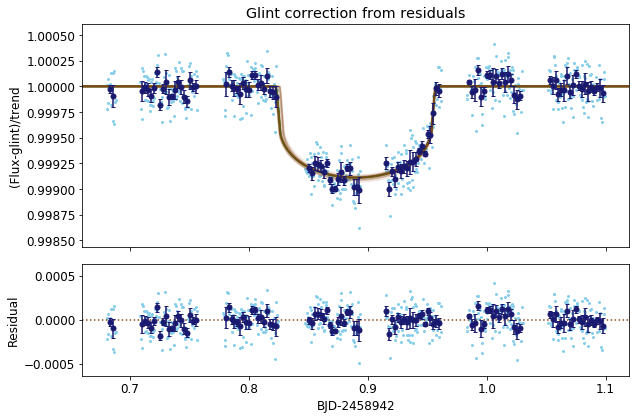

In [14]:
fig = dataset.plot_emcee(title='Glint correction from residuals', detrend=True,
                         figsize=(9,6),fontsize=12, binwidth=0.0025)

### Add correlated noise

Now use "add_shoterm=True" so that correlated noise is modelled using the SHOTerm kernel from [celerite](https://celerite.readthedocs.io/en/stable/).

Broad priors on log_sigma, log_omega0 and log_S0 from a previous run of this sampler without priors are used here to remove long tails in the distrubtions with very few samples  that mess up the plots.

In [15]:
sampler = dataset.emcee_sampler(add_shoterm=True,  
                                log_sigma=(-11,-7), log_omega0=(3.5,7.5), log_S0=(-30,-20))
print(dataset.emcee_report())

Running burn-in ..


100%|██████████| 256/256 [02:06<00:00,  2.02it/s]

Running sampler ..



100%|██████████| 512/512 [03:44<00:00,  2.28it/s]

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 32768
    # data points      = 574
    # variables        = 11
    chi-square         = 1268.46368
    reduced chi-square = 2.25304383
    Akaike info crit   = -8448.20215
    Bayesian info crit = -8400.32323
    RMS residual       = 153.9 ppm
[[Variables]]
    T_0:          0.89009383 +/- 5.1442e-04 (0.06%) (init = 0.89)
    P:            9.48926433 +/- 9.7923e-06 (0.00%) (init = 9.489264)
    D:            7.5029e-04 +/- 4.2041e-05 (5.60%) (init = 0.001224343)
    W:            0.01417801 +/- 1.2666e-04 (0.89%) (init = 0.02208278)
    b:            0.38941446 +/- 0.21654265 (55.61%) (init = 0.5)
    f_c:          0 (fixed)
    f_s:          0 (fixed)
    h_1:          0.70717794 +/- 0.01020285 (1.44%) (init = 0.71)
    h_2:          0.439 (fixed)
    c:            1.00017327 +/- 9.3032e-06 (0.00%) (init = 1)
    glint_scale:  1.02202846 +/- 0.02534798 (2.48%) (init = 1)
    k:            0.02739145 +/- 0.00110

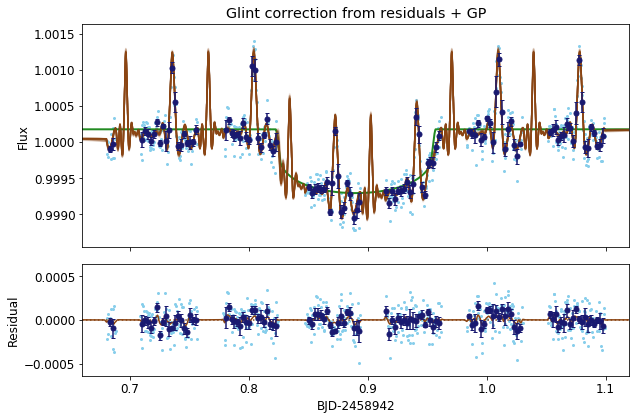

In [16]:
fig = dataset.plot_emcee(title='Glint correction from residuals + GP',
                         figsize=(9,6),fontsize=12, binwidth=0.0025)

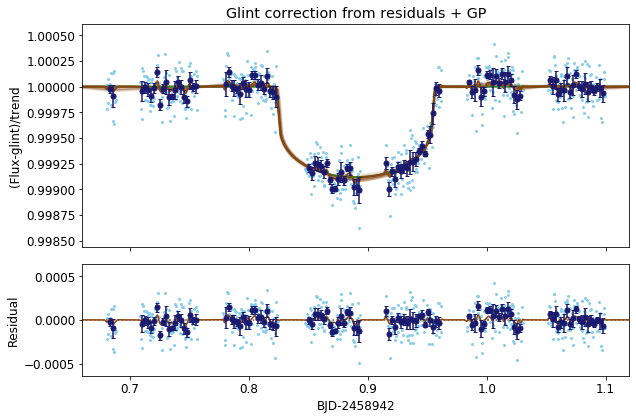

In [17]:
fig = dataset.plot_emcee(title='Glint correction from residuals + GP', detrend=True,
                         figsize=(9,6),fontsize=12, binwidth=0.0025,)

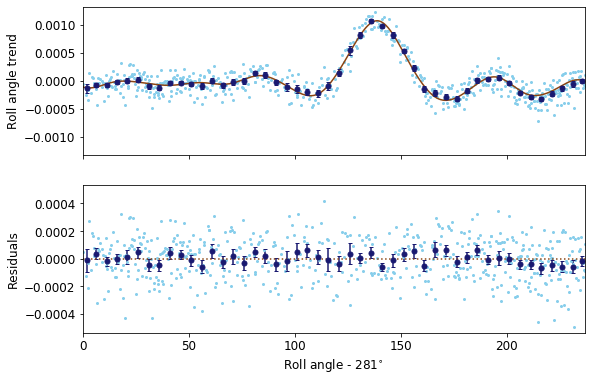

In [18]:
fig = dataset.rollangle_plot(figsize=(9,6),fontsize=12,binwidth=5)

&copy; Pierre Maxted, Keele University 2020